In [1]:
from read_data import read_enhanced_microscore_dataset
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from plots import first_plot, second_plot, third_plot, forth_plot, plot_performance, fith_plot
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np

In [2]:
df = read_enhanced_microscore_dataset()

In [3]:
df["PrecioM2"] = df["Precio"]/df["Metros"]

In [4]:
df_base = df[[
    "Habitaciones",
    "Aseos",
    "Terraza",
    "Piscina",
    "Garaje",
    "Precio",
    "PrecioM2",
    "Metros",
    # "CodigoPostal",
    "Latitud",
    "Longitud",
    'Caracteristicas'
]]

In [5]:
df_microscore = df[[
    "Habitaciones",
    "Aseos",
    "Terraza",
    "Piscina",
    "Garaje",
    "Precio",
    "PrecioM2",
    "Metros",
    # "CodigoPostal",
    "Latitud",
    "Longitud",
    "RentaBrutaHogar",
    "RentaBrutaPersona",
    "poblacion_2023",
    "%_servicios",
    "densidad_inm_m2",
    "%_agricultura",
    "%_industria",
    "%_construccion",
    'Caracteristicas',
    'University_Distance',
    'School_Distance', 'Kindergarten_Distance', 'City Center_Distance',
       'Supermarket_Distance', 'Bakery_Distance', 'Hospital_Distance',
       'Pharmacy_Distance', 'Restaurant_Distance', 'Café_Distance',
       'Park_Distance', 'Gym_Distance', 'Movie Theater_Distance',
       'Theater_Distance', 'Shopping Mall_Distance', 'Bus Stop_Distance',
       'Metro Station_Distance', 'Score'
]]

In [6]:
def prepare_data(df):
    categorical_cols = ['Caracteristicas']
    df = pd.get_dummies(df, columns=categorical_cols)
    df = df.fillna(-1)
    return df

In [7]:
df_base =prepare_data(df_base)
df_microscore =prepare_data(df_microscore)

In [8]:


#Modelo DNN
def build_dnn_model(input_dim):
    model = Sequential([
        Dense(512, input_dim=input_dim, activation='relu'),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

# KNN + DNN 
def knn_dnn_pipeline(df, n_neighbors=5, distance="manhattan", epochs=30, batch_size=32):
    X = df.drop(columns=["PrecioM2", "Precio"])  
    y_knn = df["PrecioM2"]  # Objetivo KNN: PrecioM2
    y_dnn = df["Precio"]  # Objetivo DNN: Precio
    
    kf = KFold(n_splits=5, shuffle=True, random_state=56)
    knn = KNeighborsRegressor(n_neighbors=n_neighbors, metric=distance)
    
    scaler = StandardScaler()
    
    mae_list = []
    rmse_list = []
    mape_list = []
    
    # 5-fold cross-validation
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_knn_train, y_knn_test = y_knn.iloc[train_index], y_knn.iloc[test_index]
        y_dnn_train, y_dnn_test = y_dnn.iloc[train_index], y_dnn.iloc[test_index]
        metros_test = df.iloc[test_index]["Metros"]  # Get "Metros" for test set
        
        # Escalado
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Entrenamiento KNN
        knn.fit(X_train_scaled, y_knn_train)
        
        # Prediccion PrecioM2 usando KNN
        y_pred_precio_m2 = knn.predict(X_train_scaled)
        y_test_precio_m2 = knn.predict(X_test_scaled)
        
        X_train_knn = np.hstack((X_train_scaled, y_pred_precio_m2.reshape(-1, 1)))
        X_test_knn = np.hstack((X_test_scaled, y_test_precio_m2.reshape(-1, 1)))
        
        # Entrenamiento DNN
        dnn = build_dnn_model(input_dim=X_train_knn.shape[1])
        dnn.fit(X_train_knn, y_dnn_train, epochs=epochs, batch_size=batch_size, verbose=0)
        
        # Prediccion Precio usando DNN
        y_dnn_pred = dnn.predict(X_test_knn).flatten()
        
        # Calculo rendimiento
        mae = mean_absolute_error(y_dnn_test, y_dnn_pred)
        rmse = np.sqrt(mean_squared_error(y_dnn_test, y_dnn_pred))
        mape = mean_absolute_percentage_error(y_dnn_test, y_dnn_pred)
        
        mae_list.append(mae)
        rmse_list.append(rmse)
        mape_list.append(mape)
        
        print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2%}")
    
    print("\n--- Metricas Cross-Validation ---")
    print(f"Average MAE: {np.mean(mae_list):.2f}")
    print(f"Average RMSE: {np.mean(rmse_list):.2f}")
    print(f"Average MAPE: {np.mean(mape_list):.2%}")

    return y_dnn_test, y_dnn_pred

# Example usage:
# knn_dnn_pipeline(df)


In [9]:
y_test_base, y_pred_base =knn_dnn_pipeline(df_base)

C:\Users\emebe\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
MAE: 80161.16, RMSE: 175540.09, MAPE: 35.59%


C:\Users\emebe\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
MAE: 81195.98, RMSE: 179874.24, MAPE: 35.45%


C:\Users\emebe\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
MAE: 79397.93, RMSE: 194157.41, MAPE: 33.73%


C:\Users\emebe\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
MAE: 82389.96, RMSE: 171262.70, MAPE: 35.85%


C:\Users\emebe\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
MAE: 78422.20, RMSE: 178247.72, MAPE: 32.91%

--- Cross-Validation Metrics ---
Average MAE: 80313.45
Average RMSE: 179816.43
Average MAPE: 34.71%


In [10]:
y_test_micro, y_pred_micro = knn_dnn_pipeline(df_microscore)

C:\Users\emebe\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
MAE: 64453.15, RMSE: 137461.71, MAPE: 29.56%


C:\Users\emebe\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
MAE: 66852.09, RMSE: 150177.22, MAPE: 27.80%


C:\Users\emebe\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
MAE: 68044.25, RMSE: 163458.48, MAPE: 28.58%


C:\Users\emebe\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
MAE: 65420.59, RMSE: 143605.81, MAPE: 27.06%


C:\Users\emebe\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
MAE: 67698.74, RMSE: 150853.97, MAPE: 32.54%

--- Cross-Validation Metrics ---
Average MAE: 66493.77
Average RMSE: 149111.44
Average MAPE: 29.11%


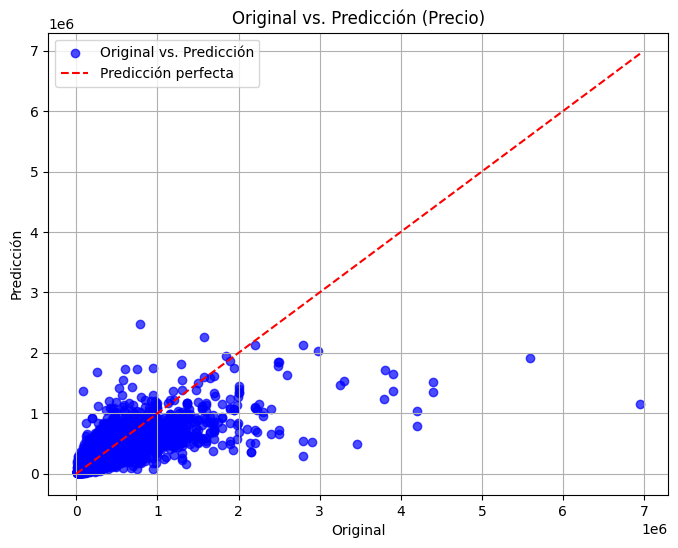

C:\Users\emebe\Documents\GitHub\tfm_cleaned\plots.py:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


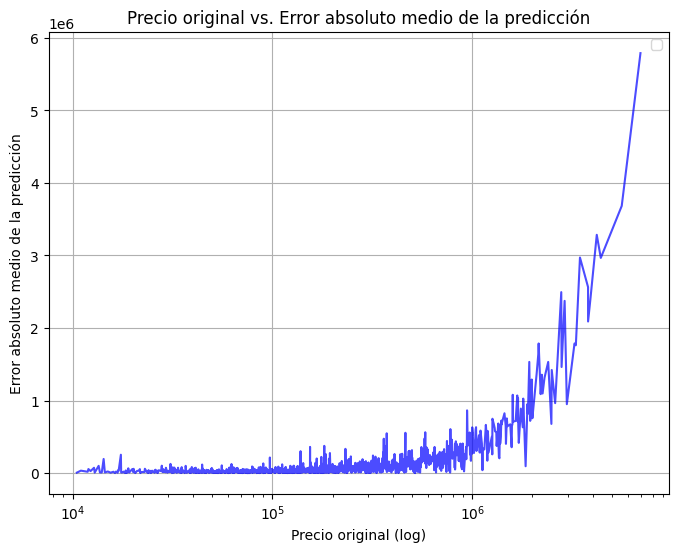

C:\Users\emebe\Documents\GitHub\tfm_cleaned\plots.py:64: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


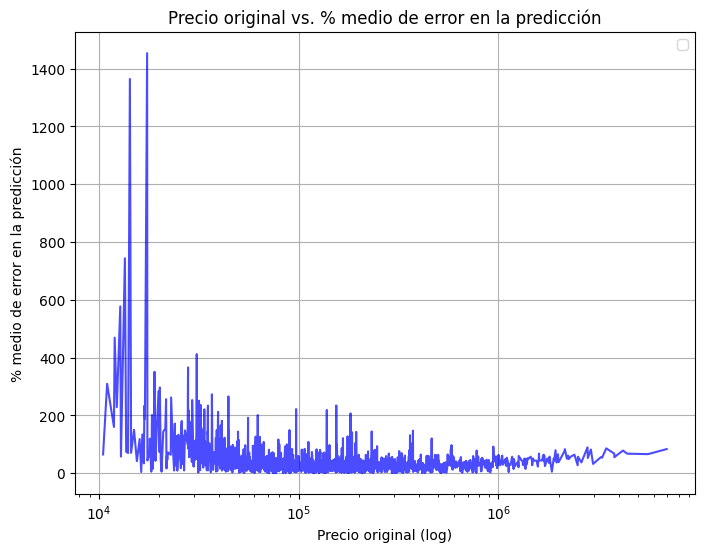

C:\Users\emebe\Documents\GitHub\tfm_cleaned\plots.py:79: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result = df_plot.groupby("log_bin")["%error"].mean().reset_index()


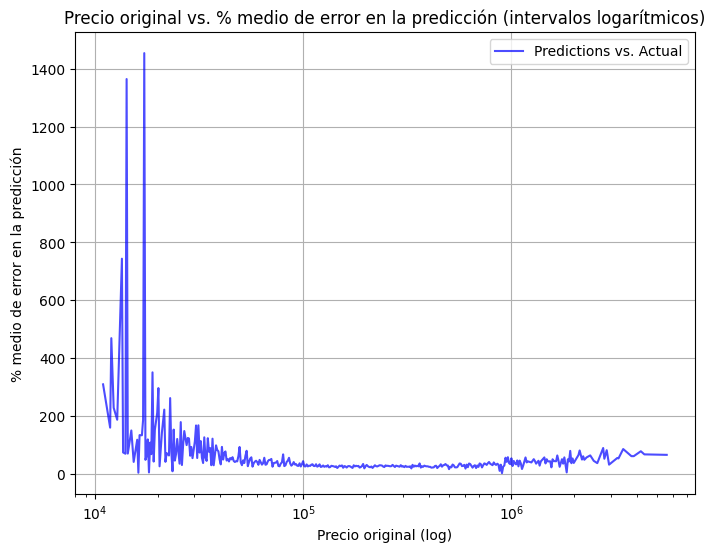

In [11]:
plot_performance(y_test_base, y_pred_base)

C:\Users\emebe\Documents\GitHub\tfm_cleaned\plots.py:156: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result_blue = df_plot_base.groupby("log_bin")["%error"].mean().reset_index()
C:\Users\emebe\Documents\GitHub\tfm_cleaned\plots.py:163: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result_red = df_plot__micro.groupby("log_bin")["%error"].mean().reset_index()


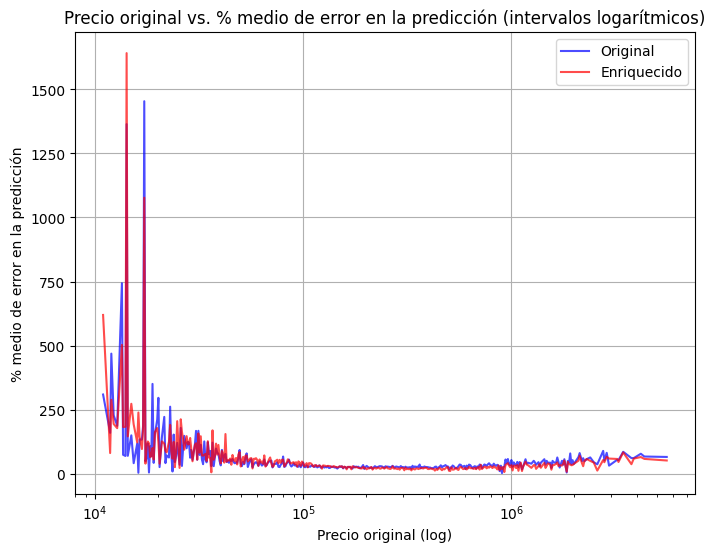

In [12]:
fith_plot(y_test_base, y_pred_base, y_test_micro, y_pred_micro)